## Transports of water along several cross-sections when diffusivity and viscosity change together

Transports across several cross sections in the domain (See plot further down)

Water transport calculated as $\Phi_w = \vec{u}\cdot\vec{a}$

| Run |  $Kv_{can}$ ($m^2s^{-1}$)   | $Kv_{out}$ ($m^2s^{-1}$)  = $A_v$  ($m^2s^{-1}$)|
|-----| :---------------------: |:-------------|
| 38  | $10^{-5}$ |  $10^{-5}$ |
| 37  | $10^{-4}$ |  $10^{-4}$ |
| 36  | $10^{-3}$ |  $10^{-3}$ |
| 43  | $10^{-7}$ |  $10^{-7}$ |
| 3D04  | $10^{-3}$ | $10^{-7}$ |
| 3D05  | $10^{-4}$ | $10^{-7}$ |
| 3D06  | $10^{-3}$ | $10^{-5}$ |
| 3D07  | $10^{-4}$ | $10^{-5}$ |

In [49]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import scipy.io
import xarray as xr

In [42]:
def calc_wat_transport_CS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.V)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))

    waterCS_flux = (dx_CS*vel_CS).sum(dim=dim_name)

    return waterCS_flux

def calc_wat_transport_AS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.V)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_AS = (vel_component.isel(Y=y_slice, Xp1=x_slice))
    dx_AS = (spacing.isel(Y=y_slice, Xp1=x_slice))

    waterAS_flux = (dx_AS*vel_AS).sum(dim=dim_name)

    return waterAS_flux

def calc_wat_transport_Vert(vel_component, x_slice, y_slice,z_index, area):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.W)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    z_index : vertical index to set horizontal section
    area: xarray, area of each cell in the cross section (grid.rA)
    dim_name: str, name of the dimension along which to sum.
    
    RETURNS:
    Time series of vertical transport through the section.
    '''
    vel_vert = (vel_component.isel(Y=y_slice, X=x_slice, Zl=z_index))
    area_section = (area.isel(Y=y_slice, X=x_slice))

    waterVert_flux = ((area_section*vel_vert).sum(dim='Y')).sum(dim='X')

    return waterVert_flux

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('Water transport [$m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)


In [4]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
state_file38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
state_file37 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run37/stateGlob.nc'
state_file36 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/stateGlob.nc'
state_file43 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run43/stateGlob.nc'
state_file3D04 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/stateGlob.nc'
state_file3D05 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/stateGlob.nc'
state_file3D06 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/stateGlob.nc'
state_file3D07 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/stateGlob.nc'

grid = xr.open_dataset(grid_file)
state38 = xr.open_dataset(state_file38)
state37 = xr.open_dataset(state_file37)
state36 = xr.open_dataset(state_file36)
state43 = xr.open_dataset(state_file43)


In [5]:
gridNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
state_file42 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc'
state_file41 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run41/stateGlob.nc'
state_file40 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run40/stateGlob.nc'
state_file50 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run50/stateGlob.nc'

gridNoC = xr.open_dataset(gridNoC_file)
state42 = xr.open_dataset(state_file42)
state41 = xr.open_dataset(state_file41)
state40 = xr.open_dataset(state_file40)
state50 = xr.open_dataset(state_file50)


### Cross-sections

In [6]:
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)

CS1_y_ind = 227
CS1b_y_ind = 267
CS1c_y_ind = 297
CS1d_y_ind = 359

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(299, 359)


AS1_x_ind = 239


In [7]:
waterCS1_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS1_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS2_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS2_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS3_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS3_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS4_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS4_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS5_flux42 = calc_wat_transport_CS(unstagger_xarray(state42.V,'Yp1'), CS5_x_slice, CS1_y_ind, gridNoC.dxG , 'X')

waterCS1_flux41 = calc_wat_transport_CS(unstagger_xarray(state41.V,'Yp1'), CS1_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS2_flux41 = calc_wat_transport_CS(unstagger_xarray(state41.V,'Yp1'), CS2_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS3_flux41 = calc_wat_transport_CS(unstagger_xarray(state41.V,'Yp1'), CS3_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS4_flux41 = calc_wat_transport_CS(unstagger_xarray(state41.V,'Yp1'), CS4_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS5_flux41 = calc_wat_transport_CS(unstagger_xarray(state41.V,'Yp1'), CS5_x_slice, CS1_y_ind, gridNoC.dxG , 'X')

waterCS1_flux40 = calc_wat_transport_CS(unstagger_xarray(state40.V,'Yp1'), CS1_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS2_flux40 = calc_wat_transport_CS(unstagger_xarray(state40.V,'Yp1'), CS2_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS3_flux40 = calc_wat_transport_CS(unstagger_xarray(state40.V,'Yp1'), CS3_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS4_flux40 = calc_wat_transport_CS(unstagger_xarray(state40.V,'Yp1'), CS4_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS5_flux40 = calc_wat_transport_CS(unstagger_xarray(state40.V,'Yp1'), CS5_x_slice, CS1_y_ind, gridNoC.dxG , 'X')

waterCS1_flux50 = calc_wat_transport_CS(unstagger_xarray(state50.V,'Yp1'), CS1_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS2_flux50 = calc_wat_transport_CS(unstagger_xarray(state50.V,'Yp1'), CS2_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS3_flux50 = calc_wat_transport_CS(unstagger_xarray(state50.V,'Yp1'), CS3_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS4_flux50 = calc_wat_transport_CS(unstagger_xarray(state50.V,'Yp1'), CS4_x_slice, CS1_y_ind, gridNoC.dxG , 'X')
waterCS5_flux50 = calc_wat_transport_CS(unstagger_xarray(state50.V,'Yp1'), CS5_x_slice, CS1_y_ind, gridNoC.dxG , 'X')


In [8]:
waterCS1_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS1_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS2_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS2_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS3_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS3_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS4_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS4_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS5_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS5_x_slice, CS1_y_ind, grid.dxG , 'X')

waterCS1_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS1_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS2_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS2_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS3_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS3_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS4_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS4_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS5_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS5_x_slice, CS1_y_ind, grid.dxG , 'X')

waterCS1_flux36= calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS1_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS2_flux36= calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS2_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS3_flux36= calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS3_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS4_flux36= calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS4_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS5_flux36= calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS5_x_slice, CS1_y_ind, grid.dxG , 'X')

waterCS1_flux43 = calc_wat_transport_CS(unstagger_xarray(state43.V,'Yp1'), CS1_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS2_flux43 = calc_wat_transport_CS(unstagger_xarray(state43.V,'Yp1'), CS2_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS3_flux43 = calc_wat_transport_CS(unstagger_xarray(state43.V,'Yp1'), CS3_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS4_flux43 = calc_wat_transport_CS(unstagger_xarray(state43.V,'Yp1'), CS4_x_slice, CS1_y_ind, grid.dxG , 'X')
waterCS5_flux43 = calc_wat_transport_CS(unstagger_xarray(state43.V,'Yp1'), CS5_x_slice, CS1_y_ind, grid.dxG , 'X')



/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


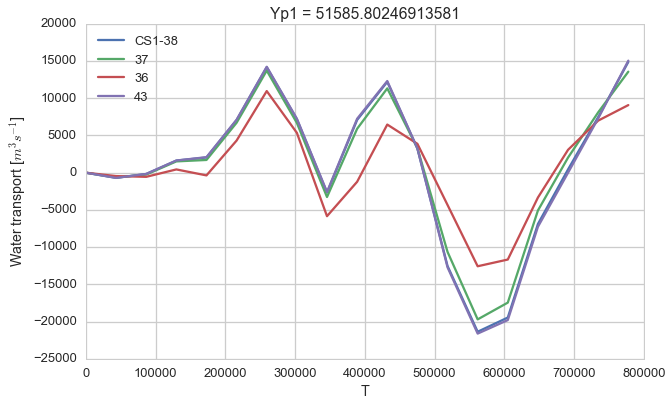

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

(waterCS1_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1-38')
(waterCS1_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS1_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS1_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


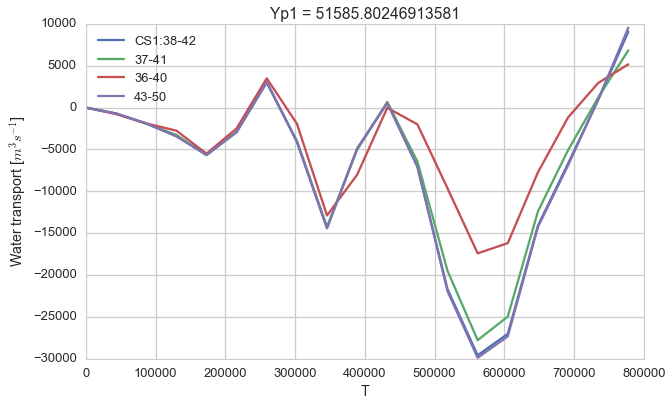

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

((waterCS1_flux38-waterCS1_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1:38-42')
((waterCS1_flux37-waterCS1_flux41)*grid.drF).sum(dim='Z').plot(ax=ax, label = '37-41')
((waterCS1_flux36-waterCS1_flux40)*grid.drF).sum(dim='Z').plot(ax=ax, label = '36-40')
((waterCS1_flux43-waterCS1_flux50)*grid.drF).sum(dim='Z').plot(ax=ax, label = '43-50')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


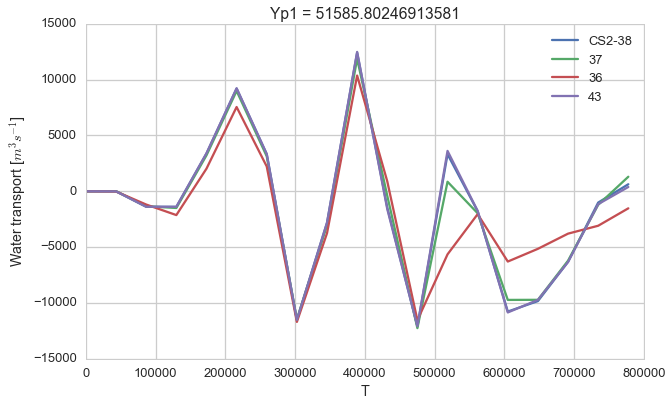

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

(waterCS2_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2-38')
(waterCS2_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS2_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS2_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


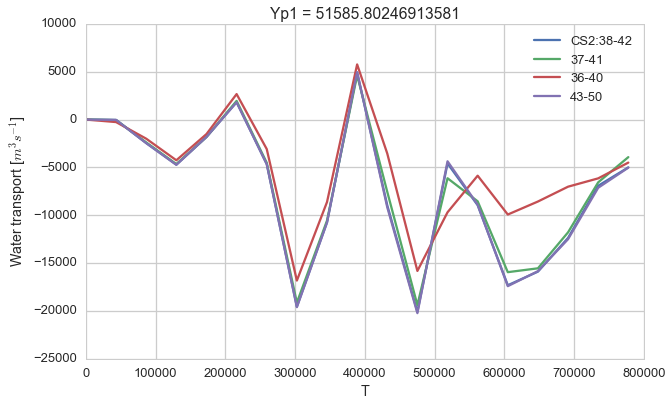

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

((waterCS2_flux38-waterCS2_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2:38-42')
((waterCS2_flux37-waterCS2_flux41)*grid.drF).sum(dim='Z').plot(ax=ax, label = '37-41')
((waterCS2_flux36-waterCS2_flux40)*grid.drF).sum(dim='Z').plot(ax=ax, label = '36-40')
((waterCS2_flux43-waterCS2_flux50)*grid.drF).sum(dim='Z').plot(ax=ax, label = '43-50')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


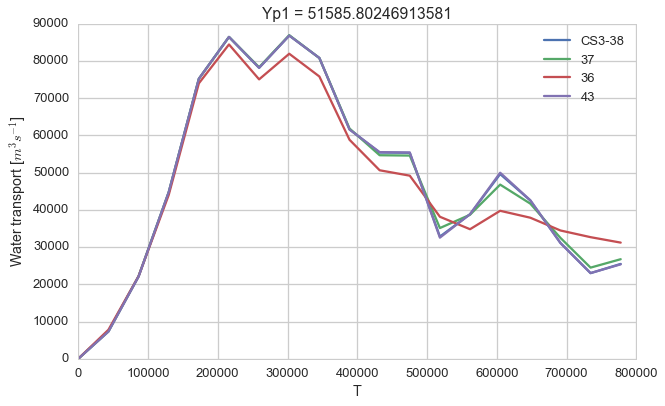

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

(waterCS3_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3-38')
(waterCS3_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS3_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS3_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


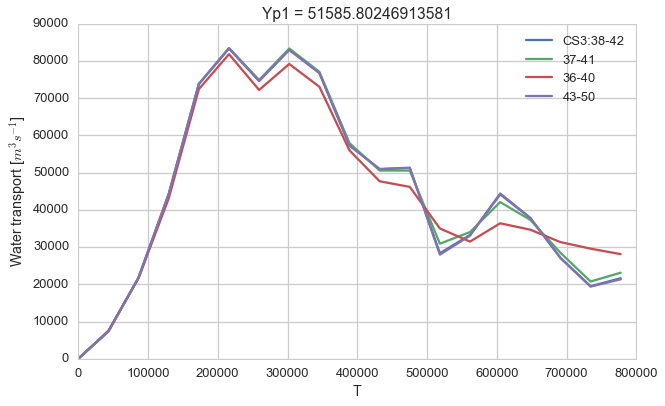

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

((waterCS3_flux38-waterCS3_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3:38-42')
((waterCS3_flux37-waterCS3_flux41)*grid.drF).sum(dim='Z').plot(ax=ax, label = '37-41')
((waterCS3_flux36-waterCS3_flux40)*grid.drF).sum(dim='Z').plot(ax=ax, label = '36-40')
((waterCS3_flux43-waterCS3_flux50)*grid.drF).sum(dim='Z').plot(ax=ax, label = '43-50')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


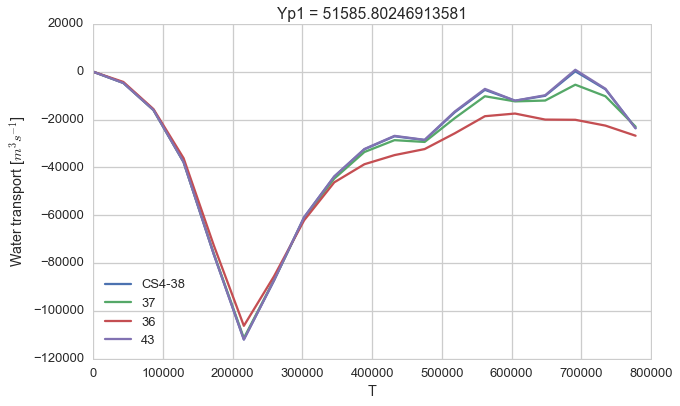

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

(waterCS4_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4-38')
(waterCS4_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS4_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS4_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


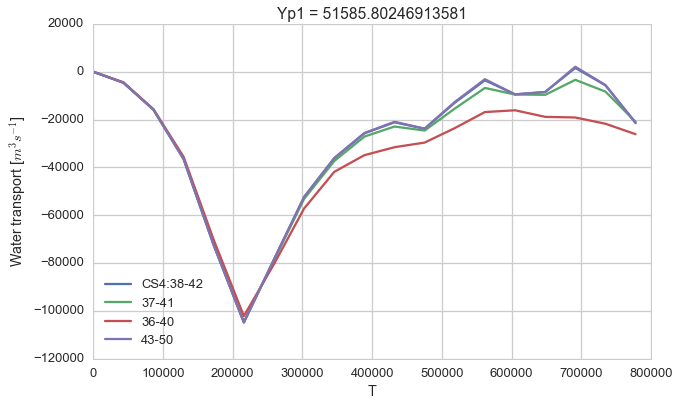

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

((waterCS4_flux38-waterCS4_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4:38-42')
((waterCS4_flux37-waterCS4_flux41)*grid.drF).sum(dim='Z').plot(ax=ax, label = '37-41')
((waterCS4_flux36-waterCS4_flux40)*grid.drF).sum(dim='Z').plot(ax=ax, label = '36-40')
((waterCS4_flux43-waterCS4_flux50)*grid.drF).sum(dim='Z').plot(ax=ax, label = '43-50')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


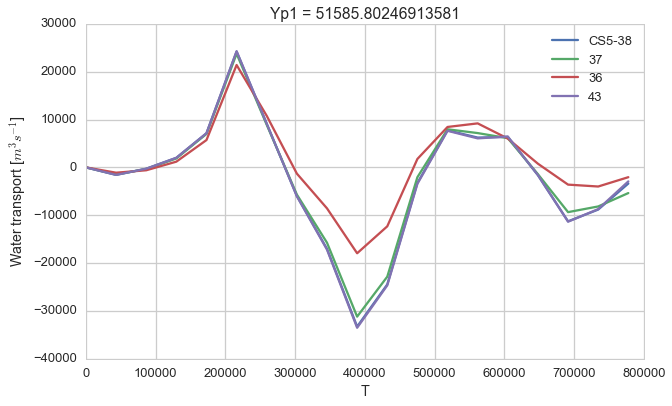

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

(waterCS5_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5-38')
(waterCS5_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS5_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS5_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

/home/kramosmu/anaconda/envs/mypython3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


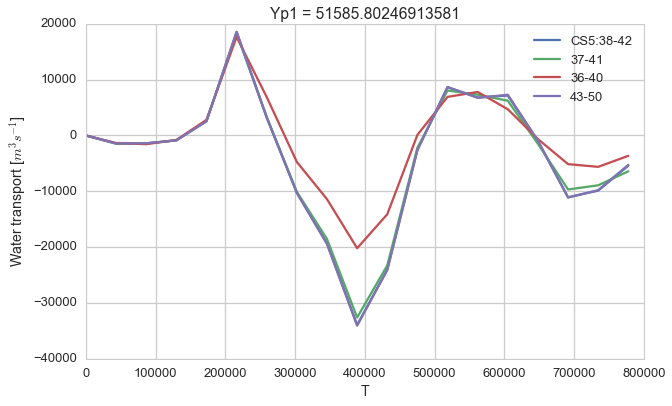

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = fig_looks(ax)

((waterCS5_flux38-waterCS5_flux42)*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5:38-42')
((waterCS5_flux37-waterCS5_flux41)*grid.drF).sum(dim='Z').plot(ax=ax, label = '37-41')
((waterCS5_flux36-waterCS5_flux40)*grid.drF).sum(dim='Z').plot(ax=ax, label = '36-40')
((waterCS5_flux43-waterCS5_flux50)*grid.drF).sum(dim='Z').plot(ax=ax, label = '43-50')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

## Alongshore transports

In [21]:
waterAS1_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS1_y_slice, grid.dyG , 'Y')
waterAS2_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS2_y_slice, grid.dyG , 'Y')
waterAS3_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS3_y_slice, grid.dyG , 'Y')

waterAS1_flux37 = calc_wat_transport_AS(unstagger_xarray(state37.U,'Xp1'), AS1_x_ind, AS1_y_slice, grid.dyG , 'Y')
waterAS2_flux37 = calc_wat_transport_AS(unstagger_xarray(state37.U,'Xp1'), AS1_x_ind, AS2_y_slice, grid.dyG , 'Y')
waterAS3_flux37 = calc_wat_transport_AS(unstagger_xarray(state37.U,'Xp1'), AS1_x_ind, AS3_y_slice, grid.dyG , 'Y')

waterAS1_flux36= calc_wat_transport_AS(unstagger_xarray(state36.U,'Xp1'), AS1_x_ind, AS1_y_slice, grid.dyG , 'Y')
waterAS2_flux36= calc_wat_transport_AS(unstagger_xarray(state36.U,'Xp1'), AS1_x_ind, AS2_y_slice, grid.dyG , 'Y')
waterAS3_flux36= calc_wat_transport_AS(unstagger_xarray(state36.U,'Xp1'), AS1_x_ind, AS3_y_slice, grid.dyG , 'Y')

waterAS1_flux43 = calc_wat_transport_AS(unstagger_xarray(state43.U,'Xp1'), AS1_x_ind, AS1_y_slice, grid.dyG , 'Y')
waterAS2_flux43 = calc_wat_transport_AS(unstagger_xarray(state43.U,'Xp1'), AS1_x_ind, AS2_y_slice, grid.dyG , 'Y')
waterAS3_flux43 = calc_wat_transport_AS(unstagger_xarray(state43.U,'Xp1'), AS1_x_ind, AS3_y_slice, grid.dyG , 'Y')



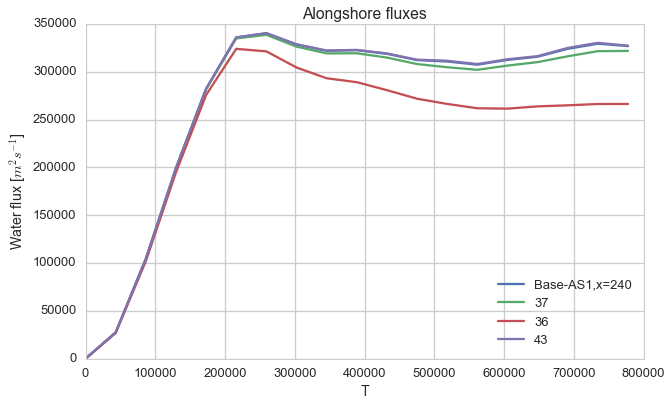

In [24]:

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS1_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Base-AS1,x=240')
(waterAS1_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterAS1_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterAS1_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

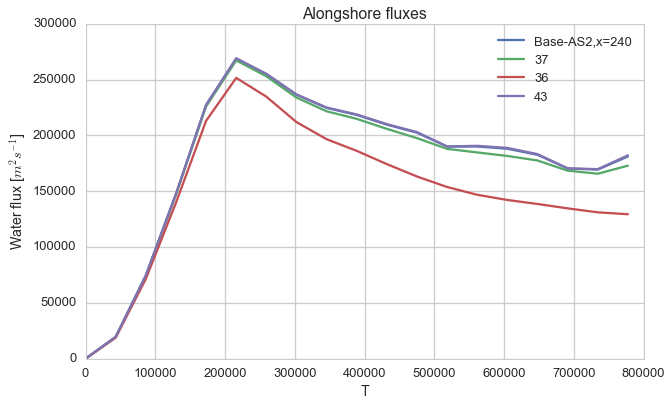

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS2_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Base-AS2,x=240')
(waterAS2_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterAS2_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterAS2_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

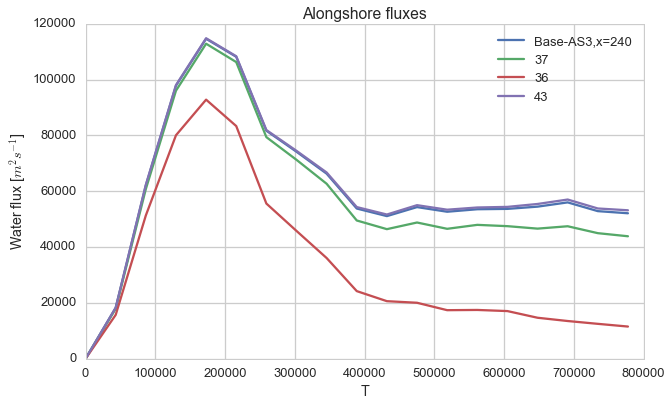

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS3_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Base-AS3,x=240')
(waterAS3_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterAS3_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterAS3_flux43*grid.drF).sum(dim='Z').plot(ax=ax, label = '43')

ax.set_ylabel('Water flux [$m^2s^{-1}$]')
ax.legend(loc=0)
ax.set_title('Alongshore fluxes')

## Vertical transports

In [46]:
hor_section_x = slice(120,240)
hor_section_y = slice(227,267)
z_index = 30

waterVert_flux38 = calc_wat_transport_Vert(state38.W, hor_section_x, hor_section_y,z_index, grid.rA)
waterVert_flux37 = calc_wat_transport_Vert(state37.W, hor_section_x, hor_section_y,z_index, grid.rA)
waterVert_flux36 = calc_wat_transport_Vert(state36.W, hor_section_x, hor_section_y,z_index, grid.rA)
waterVert_flux43 = calc_wat_transport_Vert(state43.W, hor_section_x, hor_section_y,z_index, grid.rA)

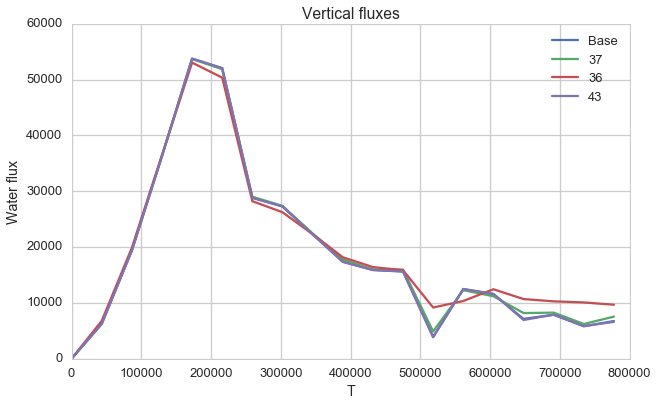

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterVert_flux38).plot(ax=ax, label = 'Base')
(waterVert_flux37).plot(ax=ax, label = '37')
(waterVert_flux36).plot(ax=ax, label = '36')
(waterVert_flux43).plot(ax=ax, label = '43')

ax.set_ylabel('Water flux')
ax.legend(loc=0)
ax.set_title('Vertical fluxes')
